# FEniCS on GPU
Author Ghanshyam Chandra

In [1]:
!nvidia-smi

Sat Jul 18 13:32:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      1MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip3 install cupy-cuda101

In [3]:
!sudo apt-get install software-properties-common
!sudo add-apt-repository ppa:fenics-packages/fenics
!sudo apt-get update
!sudo apt-get install --no-install-recommends fenics

Reading package lists... Done
Building dependency tree       
Reading state information... Done
software-properties-common is already the newest version (0.96.24.32.13).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
 This PPA provides packages for the FEniCS project.

To use this PPA, please follow the instructions at http://fenicsproject.org.
 More info: https://launchpad.net/~fenics-packages/+archive/ubuntu/fenics
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/ma

In [4]:
!pip3 install matplotlib

In [5]:
!pip3 install scipy

# Importing Libraries

In [34]:
from fenics import * 
import fenics as fe
import matplotlib.pyplot as plt 
import numpy as np 
import time
import matplotlib.pyplot as plt
import cupy
import cupyx
import scipy.sparse as sps
import scipy.sparse.linalg as spsl

# Defining Function to get SPARSE Matrix

Using Eigen as Default Linear Algebra Backend.

In [46]:
fe.parameters['linear_algebra_backend'] = 'Eigen'
def tran2SparseMatrix(A):
    row, col, val = fe.as_backend_type(A).data()
    return sps.csr_matrix((val, col, row))

Using  Poisson's Equation. \
Grid Points = 361201

In [47]:
# Create mesh and define function space
mesh = UnitSquareMesh(600, 600)
V = FunctionSpace(mesh, "Lagrange", 1)

# Define Dirichlet boundary (x = 0 or x = 1)
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS

# Define boundary condition
u0 = Constant(0.0)
bc = DirichletBC(V, u0, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)",degree=0)
g = Expression("sin(5*x[0])",degree=0)
a = inner(grad(u), grad(v))*dx
L = f*v*dx + g*v*ds

# Compute solution on GPU

A = assemble(a)
b = assemble(L)


Allocating 10.5 GB of GPU memory to cuPy

In [48]:
mempool = cupy.get_default_memory_pool()

with cupy.cuda.Device(0):
    mempool.set_limit(size=10.5*1024**3)

Applying Boundary conditions\
Converting SPARSE Matrix from dolfin.cpp.la.Matrix

In [49]:
bc.apply(A, b)
A = tran2SparseMatrix(A)
b = b[:]

# CPU
Solve Assembled Matrix with CPU using Least Square Method on all available cores. (Don't need to call MPI)\
Using SciPy on CPU (Least Square Method on Sparse Matrix)

In [ ]:
file = File('Poisson/poisson_lsqr_CPU.pvd')
u = Function(V)
start = time.time()
u.vector()[:] = spsl.lsqr(A, b)[:1][0]
end = time.time()
print("lsqr_CPU(s)",end - start)
file << u
plot(u)
plt.show()

# GPU
Using cuPy on GPU (Least Square Method on Sparse Matrix)

lsqr_GPU(s) 65.9959237575531


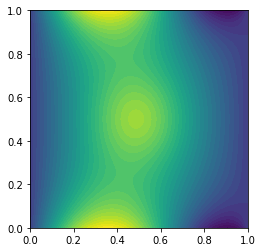

In [50]:
file = File('Poisson/poisson_lsqr_GPU.pvd')
u = Function(V)
start = time.time()
As = cupyx.scipy.sparse.csr_matrix(A)
bs = cupy.array(b)
u.vector()[:] = cupy.asnumpy(cupyx.scipy.sparse.linalg.lsqr(As, bs)[:1][0])
end = time.time()
print("lsqr_GPU(s)",end - start)
file << u
plot(u)
plt.show()